In [2]:
import numpy as np
import torch
import h5py
import torch.nn as nn
import torch_geometric
import torch.nn.functional as F
import torch_geometric.nn as PyG
from torch_geometric.transforms import Distance
from torch_geometric.data import DataLoader
from torch_geometric.data import Data as PyGData
from torch_geometric.data import Data
import sys, os
import subprocess
import csv, yaml
import math
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import torch.optim as optim
import argparse
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# f = h5py.File('/store/hep/users/jhgoh/nurion4hep/20211116_1/graph/9CED6751-B459-1442-AB96-EE3FB4F6E268.h5','r')

In [4]:
# f['events'].keys()

In [5]:
# f['events']['px'][0]

In [6]:
sys.path.append("./python")
from model.allModel import *

In [7]:
# args = parser.parse_args() ## not jupyter
import easydict
args = easydict.EasyDict({
    "config" : 'config_eval.yaml' ,
    "output" : '20220407_4top_test2',
    "epoch" : 1,
    "seed" : 12345,
    "lr" : 1e-4,
    "batch" : 1,
    "model" : 'GNN3layer',
    "fea" : 6,
    "cla" : 1,
    "device" : 3

   
})

In [8]:
config = yaml.load(open(args.config).read(), Loader=yaml.FullLoader)
config['training']['learningRate'] = float(config['training']['learningRate'])
if args.seed: config['training']['randomSeed1'] = args.seed
if args.epoch: config['training']['epoch'] = args.epoch
if args.lr: config['training']['learningRate'] = args.lr

In [9]:
torch.set_num_threads(os.cpu_count())
if torch.cuda.is_available() and args.device >= 0: torch.cuda.set_device(args.device)
if not os.path.exists('result/' + args.output): os.makedirs('result/' + args.output)

In [10]:
import time
start = time.time()
##### Define dataset instance #####
from dataset.HEPGNNDataset_h5_LHE_draw import *
dset = HEPGNNDataset_h5_LHE_draw()
for sampleInfo in config['samples']:
    if 'ignore' in sampleInfo and sampleInfo['ignore']: continue
    name = sampleInfo['name']
    dset.addSample(name, sampleInfo['path'], weight=sampleInfo['xsec']/sampleInfo['ngen'])
    dset.setProcessLabel(name, sampleInfo['label'])
dset.initialize()

4top /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-pythia8/4top_dump_ex1/220324_055935/graph/4top_ex1_8*.h5
   procName                                           fileName        weight  \
0      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
1      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
2      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
3      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
4      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
5      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
6      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
7      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
8      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
9      4top  /users/yewzzang/TTTT_TuneCP5_13TeV-amcatnlo-py...  1.004000e-09   
10     4top  /

In [11]:
lengths = [int(x*len(dset)) for x in config['training']['splitFractions']]
lengths.append(len(dset)-sum(lengths))
torch.manual_seed(config['training']['randomSeed1'])
kwargs = {'num_workers':min(config['training']['nDataLoaders'], os.cpu_count()),
          'batch_size':args.batch, 'pin_memory':False}

In [12]:
testLoader = DataLoader(dset, **kwargs)
torch.manual_seed(torch.initial_seed())

In [13]:
device = 'cuda:3'

#### Start evaluation #####
from tqdm import tqdm

datas = []
for i, data in enumerate(tqdm(testLoader)):
    
    data = data.to(device)
    datas.append(data)

100%|██████████| 275002/275002 [06:00<00:00, 763.74it/s] 


In [14]:
datas

[Batch(batch=[23], edge_index=[2, 26], ww=[1], x=[23, 4]),
 Batch(batch=[23], edge_index=[2, 26], ww=[1], x=[23, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[23], edge_index=[2, 26], ww=[1], x=[23, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]),
 Batch(batch=[22], edge_index=[2, 24], ww=[1], x=[22, 4]

In [15]:
import networkx as nx

In [21]:
def plot_graph(data):
    fig, ax = plt.subplots()
    fig.set_tight_layout(False)
#     if data.ww == 1:
#         node_color = [1,0,1]
#     else:
#         node_color = [1,1,0]
#     if len(data.batch) == 22:
    if data.ww > 0:
        node_color = [1,0,1]
    else:
        node_color = [1,1,0]
    g = torch_geometric.utils.to_networkx(data, to_undirected=False)
    pos = nx.kamada_kawai_layout(g)
    nx.draw(g,pos,with_labels=True,node_size  = 1000,font_size=40,node_color=node_color)
    plt.show()

23

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


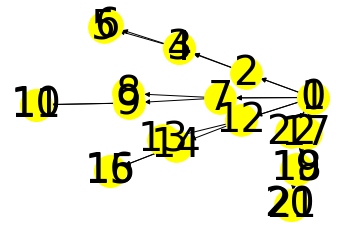

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 23


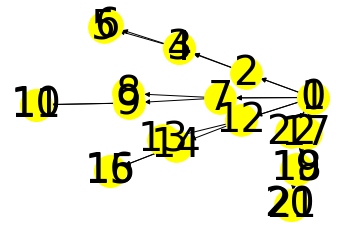

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


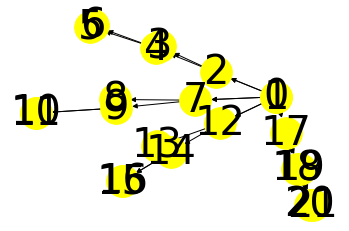

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


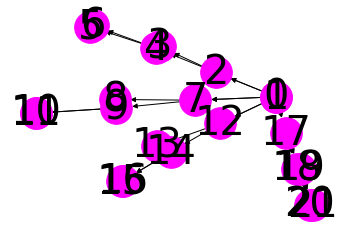

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


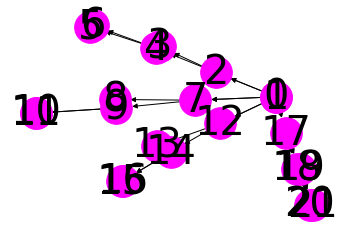

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


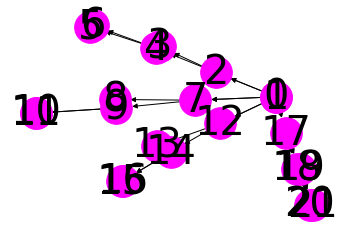

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


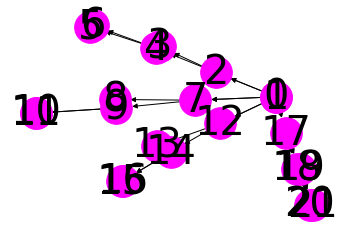

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


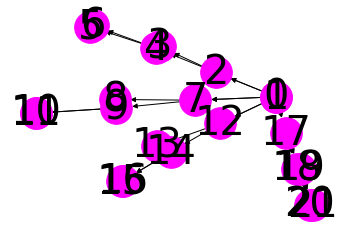

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


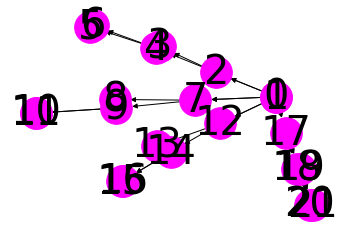

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


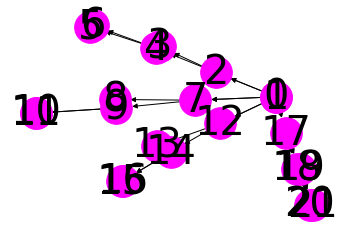

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


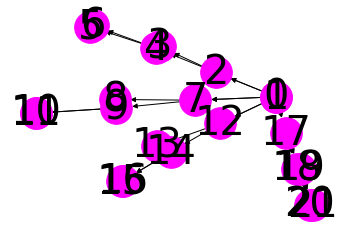

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


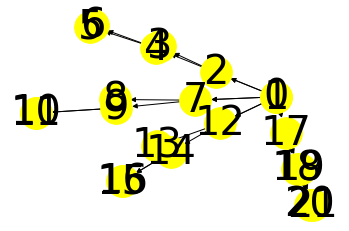

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


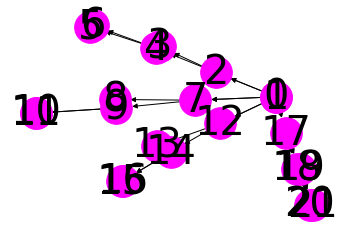

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


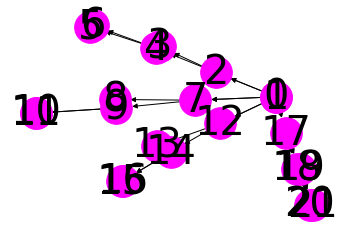

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


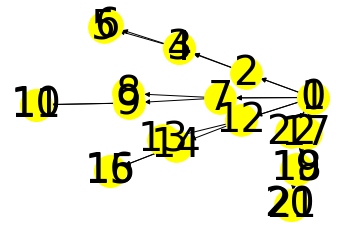

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 23


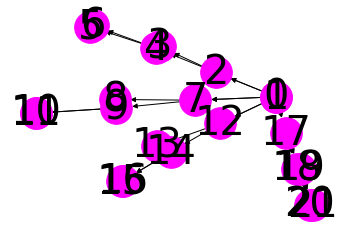

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


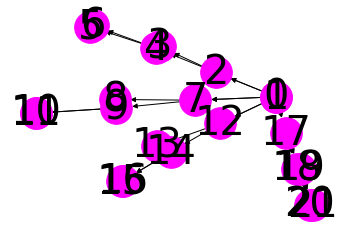

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


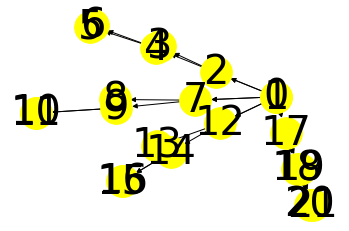

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


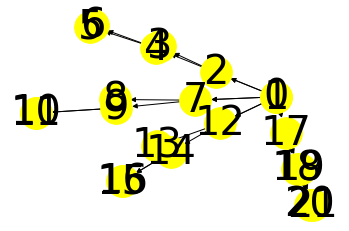

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


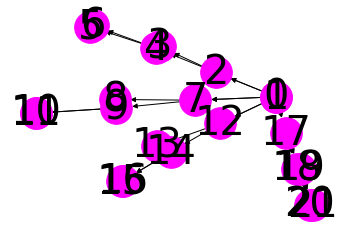

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


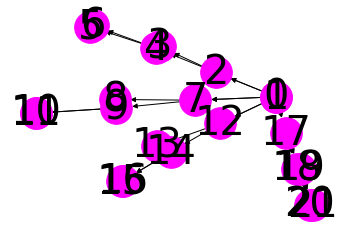

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


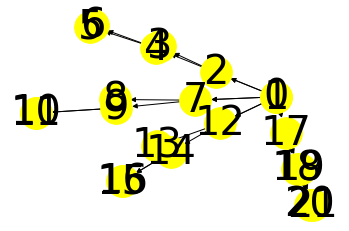

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


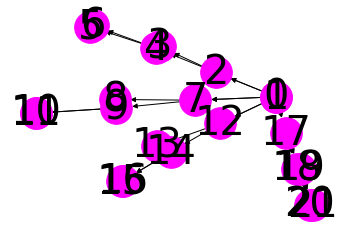

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


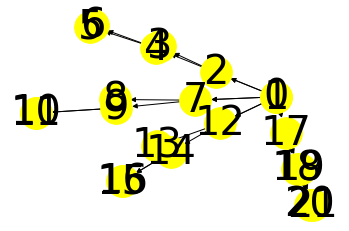

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


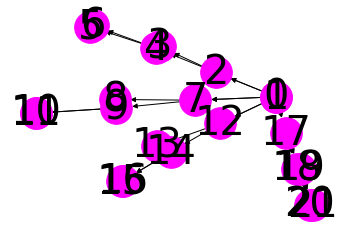

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


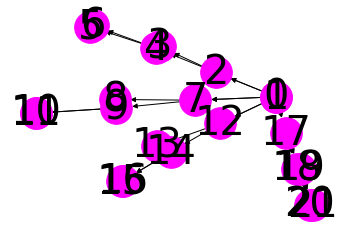

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


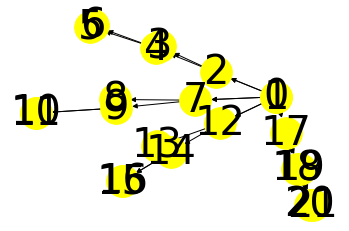

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


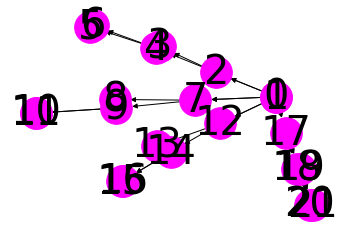

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


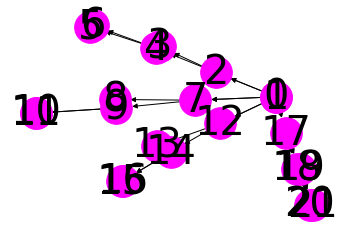

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


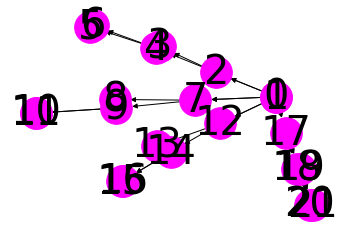

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


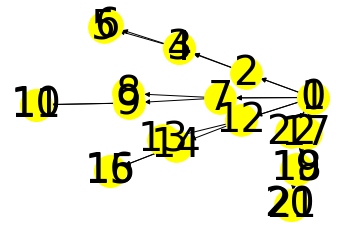

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


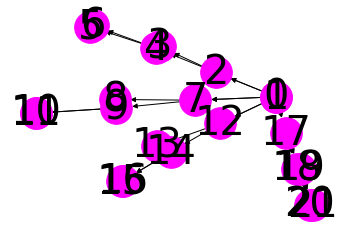

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


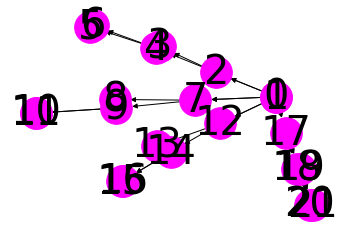

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


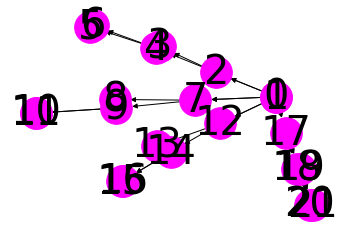

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


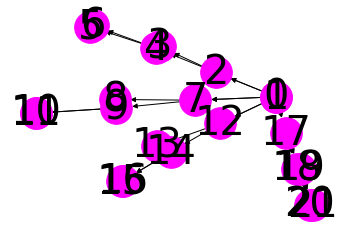

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


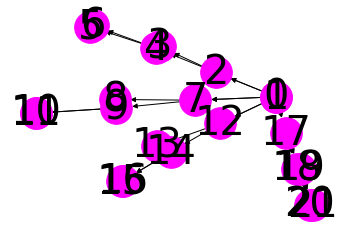

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


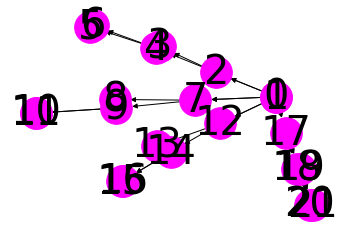

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


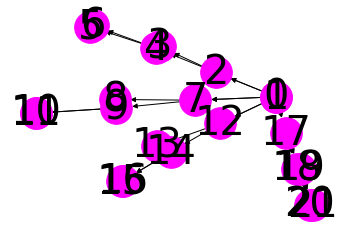

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


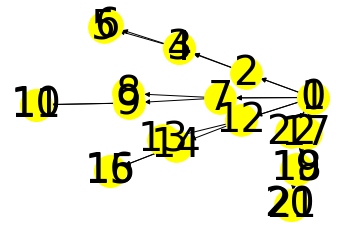

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


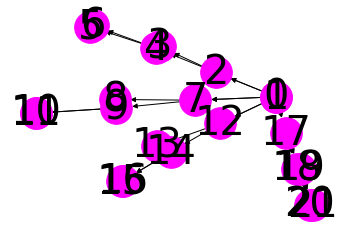

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


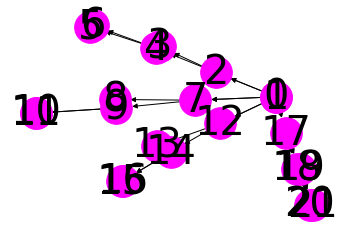

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


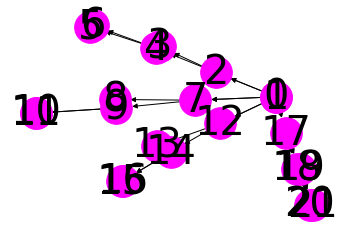

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


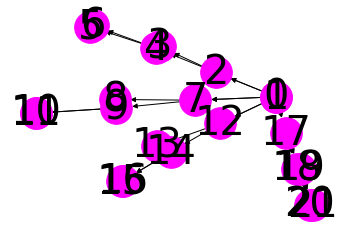

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


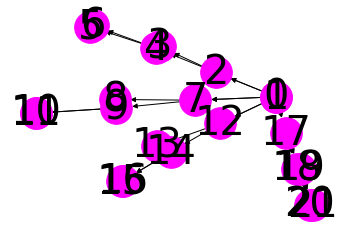

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


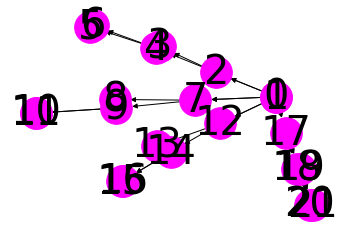

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


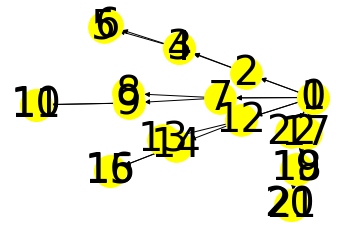

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


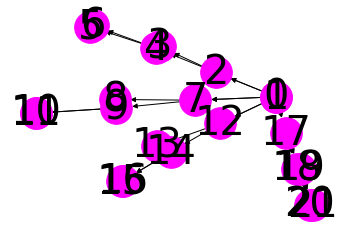

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


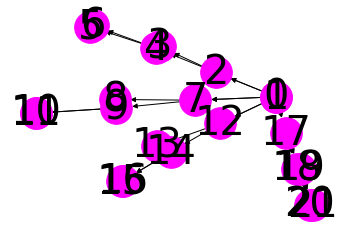

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


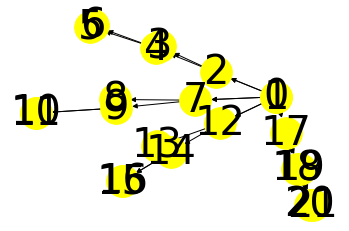

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


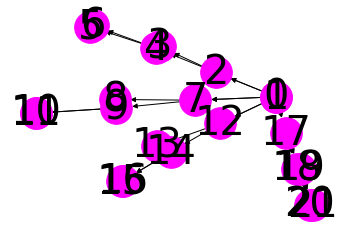

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


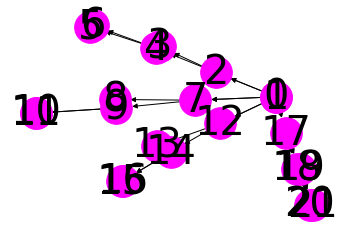

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


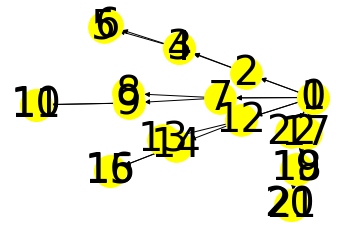

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


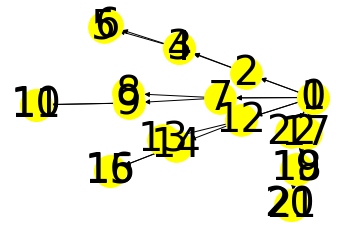

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


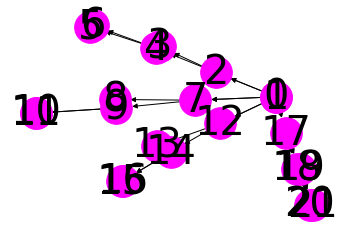

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


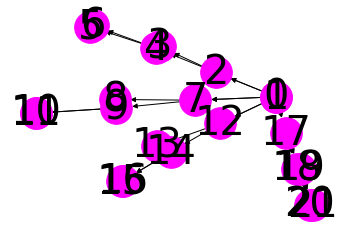

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


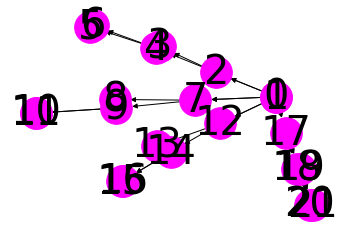

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


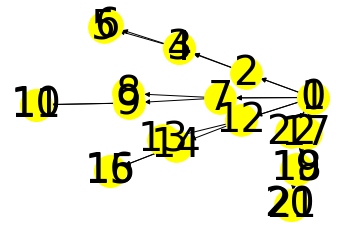

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


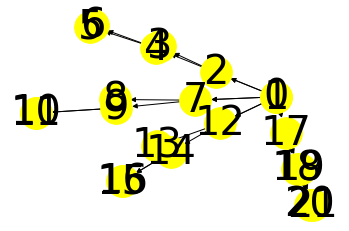

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


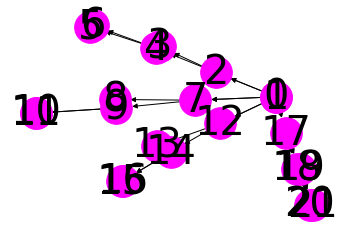

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


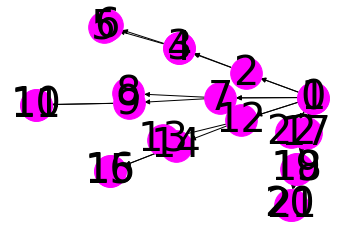

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 23


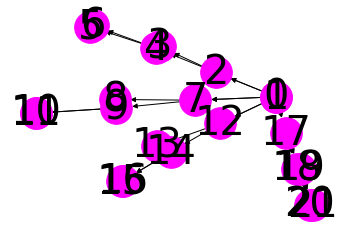

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


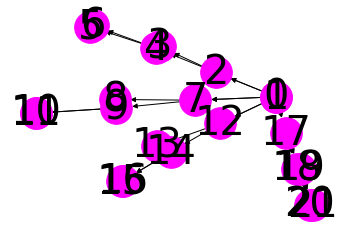

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


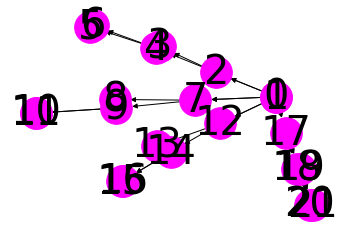

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


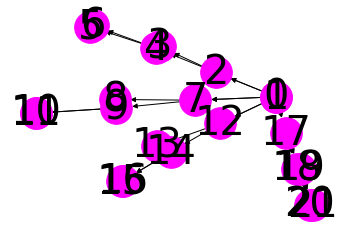

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


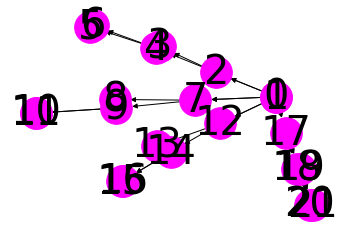

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


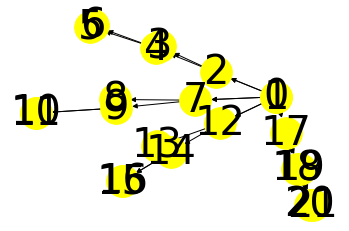

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


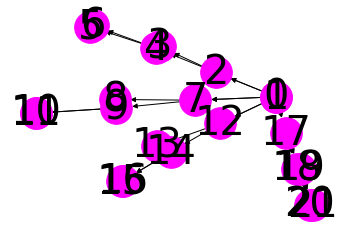

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


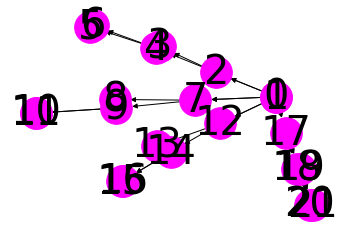

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


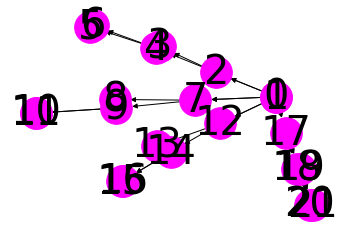

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


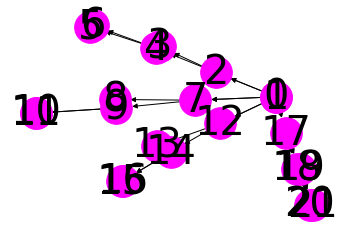

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


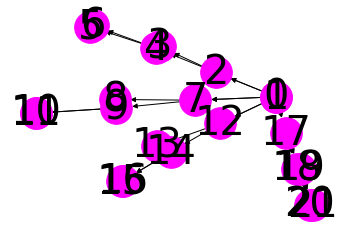

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


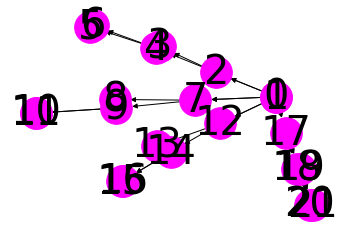

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


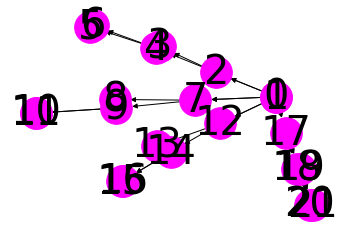

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


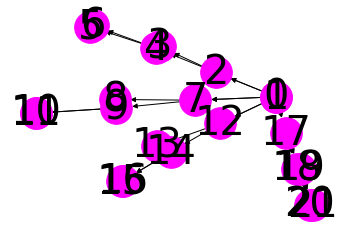

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


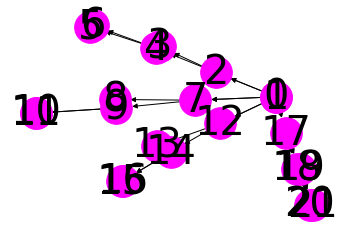

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


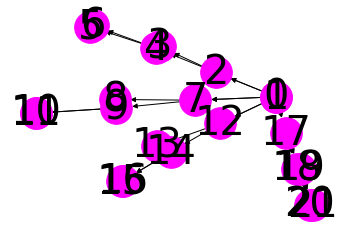

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


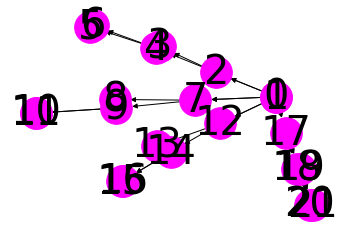

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


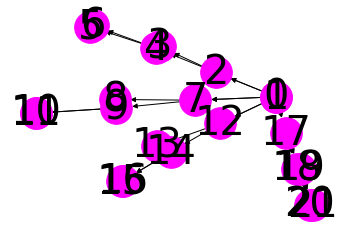

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


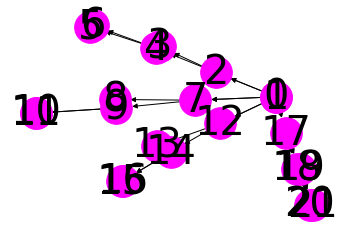

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


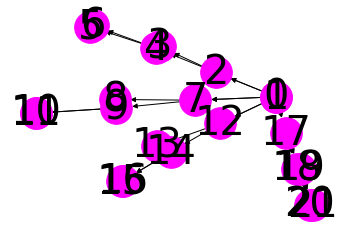

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


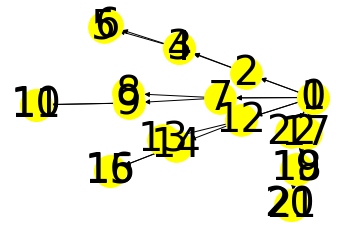

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 23


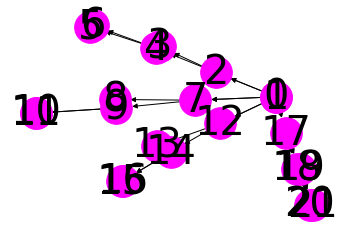

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


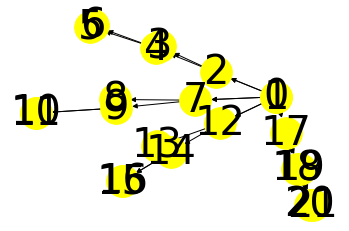

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


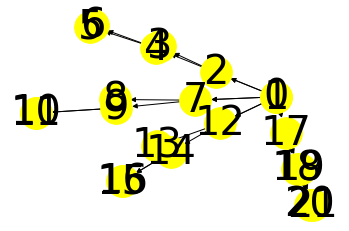

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


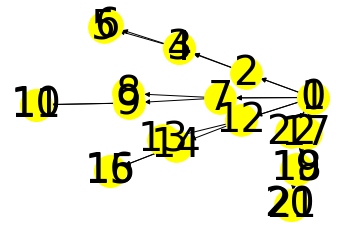

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


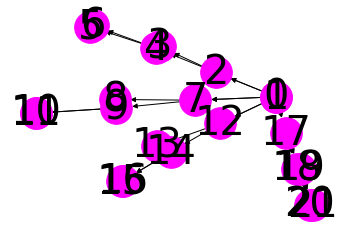

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


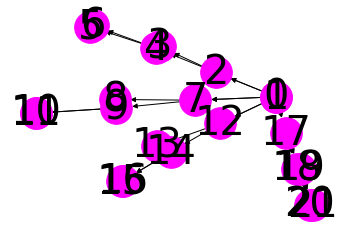

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


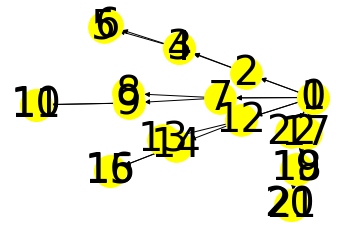

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 23


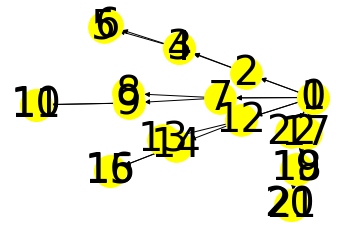

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


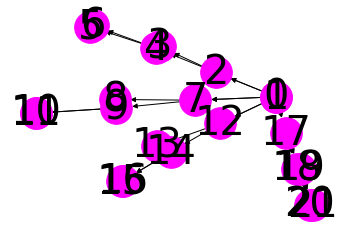

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


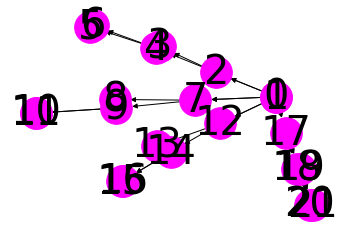

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


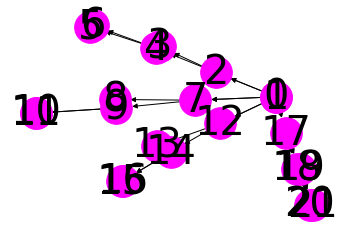

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


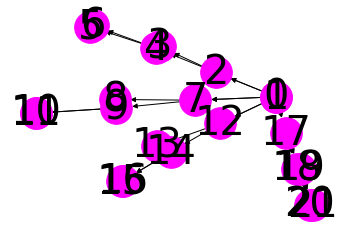

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


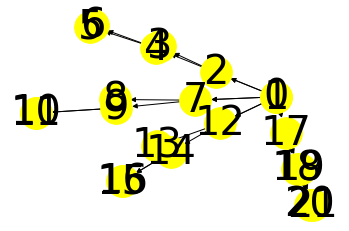

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


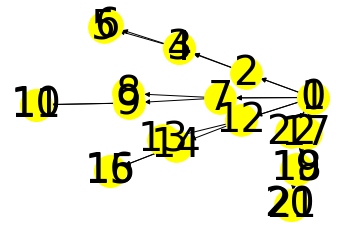

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 23


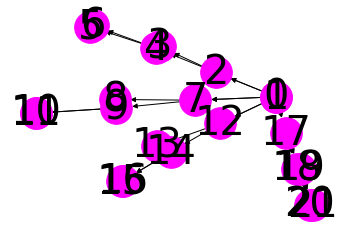

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([0.0220], device='cuda:3') 22


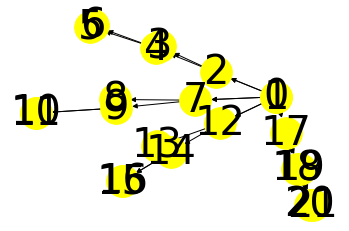

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


tensor([-0.0220], device='cuda:3') 22


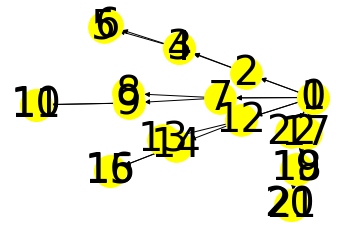

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


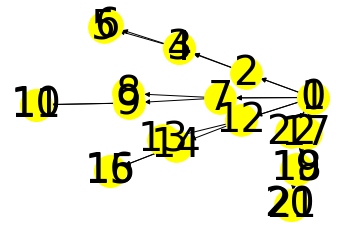

tensor([-0.0220], device='cuda:3') 23


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


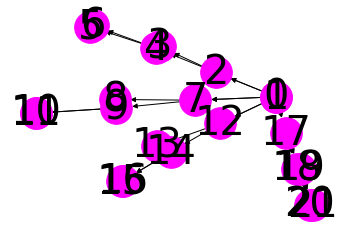

tensor([0.0220], device='cuda:3') 22


In [22]:
for i in range(100):
    plot_graph(datas[i])
    print(datas[i].ww, len(datas[i].batch))

In [18]:
for i in range(1000):
    if datas[i].x.shape[0] == 7:
        plot_graph(datas[i])
        print(datas[i].ww)
